In [ ]:
install.packages('pracma')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
#Load Libraries
library(pracma)
library(tidyverse)
library(forcats)
library(dplyr)
library(tidyr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::cross()  masks pracma::cross()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [ ]:
# Load Data
data <- read.csv("collegeData.csv")

#**PART ONE:**

##**T-Test**

In [ ]:
# Lump PrevEdCode into 10 levels
data_cleaned <- data %>%
  mutate(PrevEdCode = fct_lump(PrevEdCode, n = 10))

# T-test
t_test <- t.test(GPA ~ gradFlag, data = data_cleaned, na.rm = TRUE)

# Extract relevant t-test output
means <- tapply(data_cleaned$GPA, data_cleaned$gradFlag, mean, na.rm = TRUE)
p_value <- t_test$p.value

# Create table
t_test_table <- tibble(
  Group = c("Dropout", "Graduate"),
  Mean_GPA = means,
  P_Value = p_value
)

# Print table
print(t_test_table)

# A tibble: 2 × 3
  Group     Mean_GPA   P_Value
  <chr>    <dbl[1d]>     <dbl>
1 Dropout       2.32 5.20e-177
2 Graduate      3.40 5.20e-177


##**Chi-Square Test**

In [ ]:
# Filter and prepare data
data_cleaned <- data_cleaned %>%
  filter(!is.na(SexCode) & !is.na(MaritalCode) & !is.na(PrevEdCode) & !is.na(DDVeteran)) %>%
  mutate(across(c(SexCode, MaritalCode, PrevEdCode, DDVeteran), as.factor))

# Aggregate counts
counts <- data_cleaned %>%
  group_by(gradFlag, SexCode, MaritalCode, PrevEdCode, DDVeteran) %>%
  summarise(n = n(), .groups = "drop")

# Keep only unique groups with 10+ observations
counts <- counts %>%
  distinct() %>%
  filter(n >= 10)

# Reshape and run test
chi_sq_test <- counts %>%
  pivot_wider(names_from = gradFlag, values_from = n, values_fill = 0) %>%
  summarise(p_value = chisq.test(c(`0`, `1`))$p.value)

# Print p-values
print(chi_sq_test)

# A tibble: 1 × 1
  p_value
    <dbl>
1       0


#**PART TWO:**

In [ ]:
# Create frequency table
prev_ed_table <- data_cleaned %>%
  count(PrevEdCode)

# Print frequency table
print(prev_ed_table)

  PrevEdCode    n
1      ASSOC  363
2       BACH  474
3        GED    5
4         HS  232
5       MAST   17
6     POSTHS    2
7   SOMECOLL 1683
8         UN    8


In [ ]:
# Fit model
model <- data_cleaned %>%
  lm(GPA ~ SexCode + MaritalCode + PrevEdCode + DDVeteran, data = .)

# Tidy the model output
tidy_model <- model %>%
  broom::tidy()

# Glance at model stats
glance_model <- model %>%
  broom::glance()

# Print model outputs
print(tidy_model)
print(glance_model)

# A tibble: 15 × 5
   term               estimate std.error statistic   p.value
   <chr>                 <dbl>     <dbl>     <dbl>     <dbl>
 1 (Intercept)         3.11       0.120    26.0    2.33e-133
 2 SexCodeM           -0.149      0.0322   -4.62   3.99e-  6
 3 MaritalCodeM        0.261      0.124     2.10   3.57e-  2
 4 MaritalCodeNULL     0.00339    0.117     0.0291 9.77e-  1
 5 MaritalCodeP        0.0399     0.212     0.188  8.51e-  1
 6 MaritalCodeS        0.256      0.117     2.18   2.90e-  2
 7 MaritalCodeUN       0.0687     0.117     0.585  5.58e-  1
 8 PrevEdCodeBACH      0.134      0.0520    2.58   1.00e-  2
 9 PrevEdCodeGED      -0.436      0.333    -1.31   1.90e-  1
10 PrevEdCodeHS       -0.509      0.0627   -8.13   6.52e- 16
11 PrevEdCodeMAST      0.0962     0.184     0.523  6.01e-  1
12 PrevEdCodePOSTHS   -1.59       0.524    -3.02   2.51e-  3
13 PrevEdCodeSOMECOLL -0.209      0.0431   -4.85   1.33e-  6
14 PrevEdCodeUN       -0.822      0.265    -3.11   1.92e-  3
15 DD

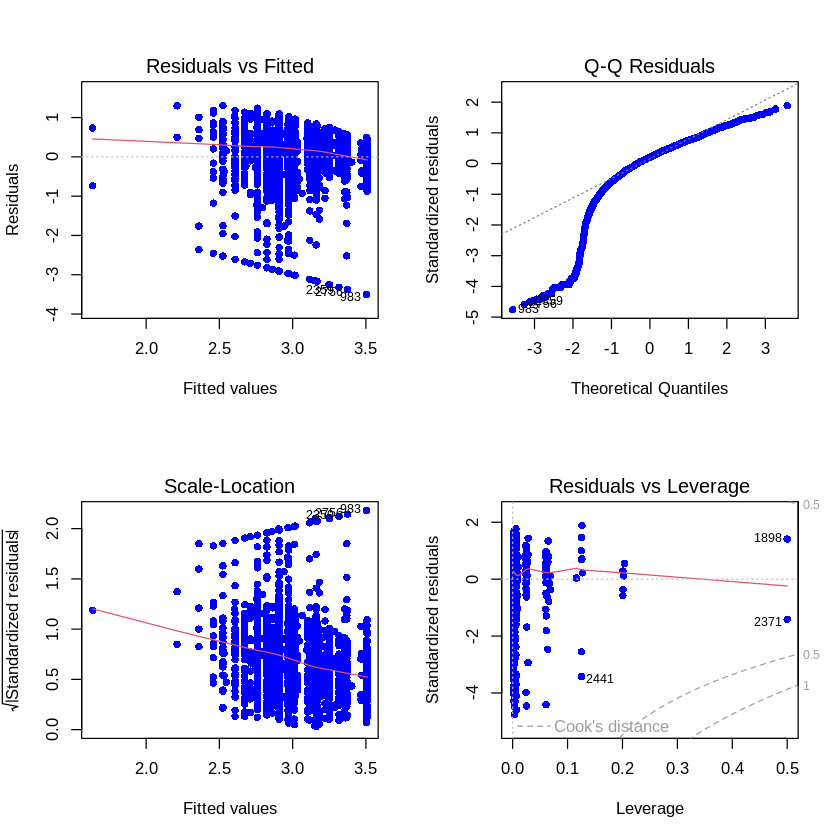

In [ ]:
# Residual analysis
par(mfrow = c(2, 2))
plot(model, pch = 16, col = "blue")

In [ ]:
print(t_test_table)
print(chi_sq_test)

# A tibble: 2 × 3
  Group     Mean_GPA   P_Value
  <chr>    <dbl[1d]>     <dbl>
1 Dropout       2.32 5.20e-177
2 Graduate      3.40 5.20e-177
# A tibble: 1 × 1
  p_value
    <dbl>
1       0


#**Residual Plots Interpretation:**

1. The residuals appear to be roughly symmetrically distributed around 0, meeting the assumption that residuals are centered at 0 with constant variance. Linear regression is reasonably suited.

2. There do not appear to be any highly influential points or outliers based on the residuals vs leverage plot. The assumptions regarding outliers/high leverage points appear to be met.

3. The residuals vs fitted values plot shows some evidence of increasing variability as the fitted values increase, indicating potential heteroscedasticity (non-constant variance). The spread of residuals appears to widen slightly at higher fitted values.

4. The normal Q-Q plot shows deviation from the reference line in the extreme upper and lower tails, indicating some departure from normality. The assumption of normality of the residuals does not appear to be fully met, which could impact hypothesis testing and inference. Consider transformations of non-normal variables.

Overall, some concerns around heteroscedasticity and non-normality that may require remedial measures. But no major violations of linear regression assumptions that would invalidate the analysis outright.

#**SUMMARY:**

Using a combination of statistical tests and regression modeling, we analyzed a dataset to uncover factors related to student academic success and likelihood of graduation.

Our analysis showed that graduates and dropouts differed significantly across several demographic and academic variables. Independent t-tests revealed graduates had higher GPAs on average compared to students who dropped out. Additionally, chi-square tests indicated significant associations between graduation status and other features like gender, marital status, prior education, and veteran status.

Based on these meaningful variables, we fitted a multiple linear regression model to predict student GPA, excluding those with 0 GPAs. The model found that factors like previous education level, veteran status, gender, and marital status all had statistically significant predictive effects on the final grades a student achieves.  

In total, our investigation illuminated several factors inherent to each student that contribute to their academic performance and probability of graduating successfully. These data-driven insights could help guide administrative decisions around enrollment, resource allocation, and student support initiatives to promote success outcomes. The methods could be adapted for future cohorts or expanded by incorporating additional potential predictors in an explanatory modeling framework.
